In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
from typing import Any
sys.path.insert(0, os.path.abspath('..'))

from src.feature_engineer import load_encoder
from src.utils.model_utils import evaulate_model, train_model
from src.utils.visualize_utils import plot_cm, get_avg_fold
from src.utils.math_utils import get_fft_power

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import torch.nn as nn
import torch
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler

from scipy.spatial.transform import Rotation

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
raw_path = "../data/raw"
encoder_path = "../models/label_encoder.pkl"

In [2]:
# preprocess
full_df = pd.merge(
    left=pd.read_csv(os.path.join(raw_path, "train.csv")),
    right=pd.read_csv(os.path.join(raw_path, "train_demographics.csv")),
    on="subject",
    how="left",
)

#! todo toremove the tof_1_v20 part
tof_of_interest = ["tof_1_v20", "tof_2_v26", "tof_3_v17", "tof_4_v5", "tof_5_v20"]
full_df = full_df.drop(columns=[col for col in full_df.columns if col not in tof_of_interest and  col.startswith("tof_")])

full_df

,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,...,tof_3_v17,tof_4_v5,tof_5_v20,adult_child,age,sex,handedness,height_cm,shoulder_to_wrist_cm,elbow_to_wrist_cm
0,SEQ_000007_000000,Target,SEQ_000007,0,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.683594,...,57.0,-1.0,-1.0,0,12,1,1,163.0,52,24.0
1,SEQ_000007_000001,Target,SEQ_000007,1,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.949219,...,68.0,-1.0,-1.0,0,12,1,1,163.0,52,24.0
2,SEQ_000007_000002,Target,SEQ_000007,2,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.722656,...,97.0,107.0,-1.0,0,12,1,1,163.0,52,24.0
3,SEQ_000007_000003,Target,SEQ_000007,3,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.601562,...,151.0,113.0,-1.0,0,12,1,1,163.0,52,24.0
4,SEQ_000007_000004,Target,SEQ_000007,4,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.566406,...,207.0,121.0,192.0,0,12,1,1,163.0,52,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574940,SEQ_065531_000048,Non-Target,SEQ_065531,48,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.503906,...,219.0,93.0,46.0,1,30,0,1,186.0,55,30.0
574941,SEQ_065531_000049,Non-Target,SEQ_065531,49,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.773438,...,216.0,82.0,50.0,1,30,0,1,186.0,55,30.0
574942,SEQ_065531_000050,Non-Target,SEQ_065531,50,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.082031,...,208.0,83.0,53.0,1,30,0,1,186.0,55,30.0
574943,SEQ_065531_000051,Non-Target,SEQ_065531,51,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.964844,...,210.0,91.0,48.0,1,30,0,1,186.0,55,30.0


In [54]:
# Clean DataFrame
def get_counts(df) -> pd.DataFrame:
    return df.groupby("sequence_id")["sequence_counter"].max() - df.groupby("sequence_id")["sequence_counter"].min() + 1


def clean_df(df: pd.DataFrame):
    non_target_gestures = df[df["sequence_type"] == "Non-Target"]["gesture"].unique()
    target_gestures = df[df["sequence_type"] == "Target"]["gesture"].unique()

    filtered_df = df[df["phase"] == "Gesture"]
    filtered_df.loc[filtered_df["sequence_type"] == "Non-Target", "gesture"] = non_target_gestures[0]

    # drop na rotation
    bad_seq_id = df[df["rot_w"].isnull()]["sequence_id"].unique()
    bad_seq_mask = filtered_df["sequence_id"].isin(bad_seq_id)
    filtered_df = filtered_df[~bad_seq_mask]
    
    #! TODO TOREMOVE, THIS REMOVES BAD THERMAL READIGNS
    for i in range(1, 6):
        bad_seq_id = df[df[f"thm_{i}"].isnull()]["sequence_id"].unique()
        bad_seq_mask = filtered_df["sequence_id"].isin(bad_seq_id)
        filtered_df = filtered_df[~bad_seq_mask]
    # end toremove

    # drop outliers in terms of count
    gesture_counts = get_counts(filtered_df)
    valid_mask = (gesture_counts >= 28) & (gesture_counts <= 35)
    print(f"{valid_mask.sum()}/{len(valid_mask)}")
    valid_idx = gesture_counts[valid_mask].index

    filtered_df = filtered_df[filtered_df["sequence_id"].isin(valid_idx)]

    return filtered_df, target_gestures


def normalize_sequence_count(df: pd.DataFrame, group_col: str, max_count: int, seq_counter_col: str = "sequence_counter") -> pd.DataFrame:
    """
    Adds gesture_counter_length with a value of the length of the elmeents of teh array
    it gets maximum + 1, so it is the execlusive end
    """
    out_groups = []

    for _, group in df.groupby(group_col, sort=False):
        g = group.copy()
        # compute length for this group
        group_count = g[seq_counter_col].max() - g[seq_counter_col].min() + 1
        needed = max_count - group_count

        # broadcast the group length to existing rows
        g["gesture_counter_length"] = group_count
        # g["is_original"] = 1

        if needed > 0:
            last = g.iloc[-1].copy()
            repeats = pd.DataFrame([last] * needed)

            # continue the sequence_counter for appended rows
            start = int(last[seq_counter_col])
            repeats[seq_counter_col] = range(start + 1, start + 1 + needed)

            # ensure the appended rows also carry the same group length
            repeats["gesture_counter_length"] = group_count
            # repeats["is_original"] = 0

            g = pd.concat([g, repeats], ignore_index=True)

        out_groups.append(g)

    return pd.concat(out_groups, ignore_index=True)

In [55]:
filtered_df, target_gestures = clean_df(full_df)

max_global_count = get_counts(filtered_df).max()
filtered_df = normalize_sequence_count(
    filtered_df,
    "sequence_id",
    max_global_count,
)

filtered_df

6775/7592


,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,...,tof_4_v5,tof_5_v20,adult_child,age,sex,handedness,height_cm,shoulder_to_wrist_cm,elbow_to_wrist_cm,gesture_counter_length
0,SEQ_000007_000025,Target,SEQ_000007,25,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,7.027344,...,-1.0,-1.0,0,12,1,1,163.0,52,24.0,32
1,SEQ_000007_000026,Target,SEQ_000007,26,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,6.984375,...,-1.0,-1.0,0,12,1,1,163.0,52,24.0,32
2,SEQ_000007_000027,Target,SEQ_000007,27,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,7.027344,...,-1.0,-1.0,0,12,1,1,163.0,52,24.0,32
3,SEQ_000007_000028,Target,SEQ_000007,28,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,6.488281,...,-1.0,-1.0,0,12,1,1,163.0,52,24.0,32
4,SEQ_000007_000029,Target,SEQ_000007,29,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,6.988281,...,-1.0,-1.0,0,12,1,1,163.0,52,24.0,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237120,SEQ_065531_000051,Non-Target,SEQ_065531,51,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.964844,...,91.0,48.0,1,30,0,1,186.0,55,30.0,32
237121,SEQ_065531_000052,Non-Target,SEQ_065531,52,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,4.269531,...,88.0,48.0,1,30,0,1,186.0,55,30.0,32
237122,SEQ_065531_000052,Non-Target,SEQ_065531,53,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,4.269531,...,88.0,48.0,1,30,0,1,186.0,55,30.0,32
237123,SEQ_065531_000052,Non-Target,SEQ_065531,54,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,4.269531,...,88.0,48.0,1,30,0,1,186.0,55,30.0,32


In [56]:
def rotation_feature_engineer(df: pd.DataFrame):
    quat = df[["rot_w", "rot_x", "rot_y", "rot_z"]]
    rotation_object = Rotation.from_quat(quat)
    rotation_vectors = rotation_object.as_rotvec()

    df["rotvec_x"] = rotation_vectors[:, 0]
    df["rotvec_y"] = rotation_vectors[:, 1]
    df["rotvec_z"] = rotation_vectors[:, 2]
    df["rot_angle"] = np.linalg.norm(rotation_vectors, axis=1)

    df["rotvec_y_diff"] = df.groupby("sequence_id")["rotvec_y"].transform(lambda x: x.diff().fillna(0))
    df["rotvec_x_diff"] = df.groupby("sequence_id")["rotvec_x"].transform(lambda x: x.diff().fillna(0))
    df["rotvec_z_diff"] = df.groupby("sequence_id")["rotvec_z"].transform(lambda x: x.diff().fillna(0))
    df["angular_mag"] = np.linalg.norm([df["rotvec_x_diff"], df["rotvec_y_diff"], df["rotvec_z_diff"]], axis=0)
    
    return df

def accelrometer_feature_engineer(df: pd.DataFrame):
    cols_of_interest = ["acc_x", "acc_y", "acc_z"]

    for col in cols_of_interest:
        df[f"fft_{col}"] = df.groupby("sequence_id")[col].transform(get_fft_power)

    df["acc_mag"] = np.linalg.norm([df["acc_x"], df["acc_y"], df["acc_z"]], axis=0)
    
    return df

filtered_df = rotation_feature_engineer(filtered_df)
filtered_df = accelrometer_feature_engineer (filtered_df)

filtered_df

,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,...,rotvec_z,rot_angle,rotvec_y_diff,rotvec_x_diff,rotvec_z_diff,angular_mag,fft_acc_x,fft_acc_y,fft_acc_z,acc_mag
0,SEQ_000007_000025,Target,SEQ_000007,25,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,7.027344,...,0.927352,1.235290,0.000000,0.000000,0.000000,0.000000,29171.0,19688.0,11033.0,9.924192
1,SEQ_000007_000026,Target,SEQ_000007,26,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,6.984375,...,0.898660,1.210973,-0.009322,-0.003831,-0.028692,0.030410,25.0,61.0,192.0,10.113299
2,SEQ_000007_000027,Target,SEQ_000007,27,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,7.027344,...,0.924279,1.214547,-0.002796,0.032691,0.025619,0.041628,76.0,24.0,66.0,10.536305
3,SEQ_000007_000028,Target,SEQ_000007,28,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,6.488281,...,0.970921,1.261463,0.061592,0.050705,0.046642,0.092412,21.0,0.0,86.0,9.782531
4,SEQ_000007_000029,Target,SEQ_000007,29,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,6.988281,...,0.977821,1.270877,0.017812,0.014674,0.006900,0.024087,0.0,0.0,1.0,9.925453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237120,SEQ_065531_000051,Non-Target,SEQ_065531,51,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.964844,...,1.274430,2.782735,-0.009463,-0.010090,-0.038689,0.041088,4.0,6.0,18.0,9.919849
237121,SEQ_065531_000052,Non-Target,SEQ_065531,52,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,4.269531,...,1.282122,2.796136,0.012956,0.013186,0.007692,0.020022,3.0,0.0,2.0,10.574324
237122,SEQ_065531_000052,Non-Target,SEQ_065531,53,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,4.269531,...,1.282122,2.796136,0.000000,0.000000,0.000000,0.000000,31.0,4.0,19.0,10.574324
237123,SEQ_065531_000052,Non-Target,SEQ_065531,54,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,4.269531,...,1.282122,2.796136,0.000000,0.000000,0.000000,0.000000,0.0,0.0,10.0,10.574324


In [63]:
target_df = filtered_df["gesture"]
encoder = load_encoder(encoder_path, target_df)  # type: ignore

features_of_interest = [
    "gesture_counter_length",
    "acc_x",
    "acc_y",
    "acc_z",
    "fft_acc_x",
    "fft_acc_y",
    "fft_acc_z",
    # "acc_mag",  # model dropped with this
    #
    "rotvec_x",
    "rotvec_y",
    "rotvec_z",
    "rot_angle",
    "angular_mag",
    
    "tof_1_v20",
    "thm_2",
    "thm_4",
    "thm_5",
]

sequence_groups = filtered_df.groupby("sequence_id")

feature_np = np.array([group for _, group in sequence_groups[features_of_interest]], dtype=np.float32)
target_np = np.array([encoder.transform(group.unique()) for _, group in sequence_groups["gesture"]])

In [64]:
# encoder

target_tensor = torch.tensor(target_np, dtype=torch.long).squeeze(1)
target_gestures_encoded = torch.tensor(encoder.transform(target_gestures))

feature_tensor = torch.tensor(feature_np)
feature_tensor.shape, target_tensor.shape

(torch.Size([6775, 35, 16]), torch.Size([6775]))

In [65]:
class SimpleModel(nn.Module):
    def __init__(self, n_channels, n_classes):
        super().__init__()

        self.conv_layer = nn.Sequential(
            nn.Conv1d(n_channels, 64, kernel_size=15, stride=5),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.BatchNorm1d(64),
            #
            nn.AdaptiveAvgPool1d(1),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, n_classes),
        )

    def forward(self, x: torch.Tensor):
        """
        X shape: B x n_timesteps x n_features
        """
        
        x = x.permute(0, 2, 1) # B x n_features x n_timesteps
        x = self.conv_layer(x)
        
        y_pred = self.fc(x)

        return y_pred


dummy_input = torch.rand(64, 35, 15)
dummy_model = SimpleModel(15, len(encoder.classes_))
dummy_model(dummy_input)

tensor([[-4.4749e-01,  7.5452e-02, -1.1746e-01,  8.5704e-02, -6.8369e-03,
          2.2005e-01,  6.9172e-02, -2.2055e-02, -7.1268e-02],
        [-2.1969e-01, -9.4846e-02, -2.4210e-03, -1.6329e-01,  3.5167e-01,
         -1.4303e-01,  4.4732e-01,  3.3841e-01, -5.2993e-01],
        [-5.4480e-01,  6.4299e-01, -4.9825e-02, -5.2766e-01, -1.2366e-01,
          2.0395e-01,  1.1372e-02, -6.3789e-02, -2.0160e-01],
        [ 1.2742e-01,  2.2323e-01, -1.6493e-01, -8.2996e-01,  2.6106e-01,
          3.8478e-01,  5.3606e-01,  2.6398e-01,  3.5818e-01],
        [ 7.2509e-02,  1.4818e-02, -3.3740e-02,  2.6660e-01, -6.3217e-02,
          1.9108e-01, -5.8607e-02,  2.8102e-01, -4.7140e-01],
        [-1.5916e-02,  1.2040e-01, -1.1878e-01, -1.1723e-01, -2.2412e-01,
         -7.6045e-02,  1.0517e-01,  1.1267e-01, -7.0897e-02],
        [-8.9206e-02,  3.4291e-01, -6.9806e-02, -1.1998e-01, -4.1305e-01,
         -3.2077e-01,  1.4359e-01, -7.9729e-04, -2.3918e-01],
        [-3.8901e-02, -1.9099e-01, -1.1944e-01, 

In [68]:
n_features = feature_tensor.shape[-1]
batch_size = 64
n_epochs = 100
n_splits = 5

gkf = GroupKFold(n_splits)

X_test_arr = []
X_train_arr = []
y_train_arr = []
y_test_arr = []

test_subjects = []
folds_score = []

subject_per_sequence = np.array([
    group.iloc[0] for _, group in sequence_groups['subject']
])
for fold, (train_indices, test_indices) in enumerate(gkf.split(X=feature_tensor, y=target_tensor, groups=subject_per_sequence)): # type: ignore
    test_subjects.append(np.unique(subject_per_sequence[test_indices]))
    X_train, y_train = feature_tensor[train_indices], target_tensor[train_indices]
    X_test, y_test = feature_tensor[test_indices], target_tensor[test_indices]
    
    mean = X_train.view(-1, X_train.size(-1)).mean(dim=0)   # shape (F,)
    std  = X_train.view(-1, X_train.size(-1)).std(dim=0) + 1e-8  # shape (F,)

    # Normalize
    X_train = (X_train - mean[None, None, :]) / std[None, None, :]
    X_test  = (X_test  - mean[None, None, :]) / std[None, None, :]
    
    X_train_arr.append(X_train.numpy())
    X_test_arr.append(X_test.numpy())
    y_train_arr.append(y_train.numpy())
    y_test_arr.append(y_test.numpy())
    
    dataset_train = TensorDataset(X_train, y_train)
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True) # uh not sure if i should keep shuffle or no
    
    model = SimpleModel(n_features, len(encoder.classes_)).to(device)
    
    model.train()
    train_model(model, dataloader_train, n_epochs, True)

    model.eval()
    score_dashboard = evaulate_model(model, X_test, y_test, target_gestures_encoded, encoder)
    folds_score.append(score_dashboard)

0 - loss_avg: 1.6355872056063483
20 - loss_avg: 0.9403466652421391
40 - loss_avg: 0.8198564171791076
60 - loss_avg: 0.7537694215774536
80 - loss_avg: 0.7105249208562514
0 - loss_avg: 1.6694825551089119
20 - loss_avg: 0.950433484245749
40 - loss_avg: 0.8494996498612797
60 - loss_avg: 0.7736957367728738
80 - loss_avg: 0.7488814357449026
0 - loss_avg: 1.5908365095362944
20 - loss_avg: 0.9068851302651798
40 - loss_avg: 0.7942588799140032
60 - loss_avg: 0.7421526810702156
80 - loss_avg: 0.6923726144958945
0 - loss_avg: 1.622376896353329
20 - loss_avg: 0.9224091256366057
40 - loss_avg: 0.8204612051739412
60 - loss_avg: 0.7599487536093767
80 - loss_avg: 0.7111078640993904
0 - loss_avg: 1.639494527087492
20 - loss_avg: 0.9296124023549697
40 - loss_avg: 0.8109097621020149
60 - loss_avg: 0.7514638746485991
80 - loss_avg: 0.6983984196887297


macro: 0.48, binary: 0.95, competition: 0.72


,precision,recall,f1-score,support
Above ear - pull hair,0.618477,0.578206,0.595344,109.200000
Cheek - pinch skin,0.411161,0.443223,0.425904,113.800000
Eyebrow - pull hair,0.381362,0.305530,0.333129,114.400000
Eyelash - pull hair,0.459525,0.406993,0.430197,111.800000
Forehead - pull hairline,0.438740,0.436204,0.435188,110.800000
Forehead - scratch,0.488644,0.534572,0.500171,112.800000
Neck - pinch skin,0.342182,0.301480,0.319099,111.200000
Neck - scratch,0.399956,0.400041,0.397477,110.400000
Write name on leg,0.882157,0.933317,0.906424,460.600000
accuracy,0.598211,0.598211,0.598211,0.598211


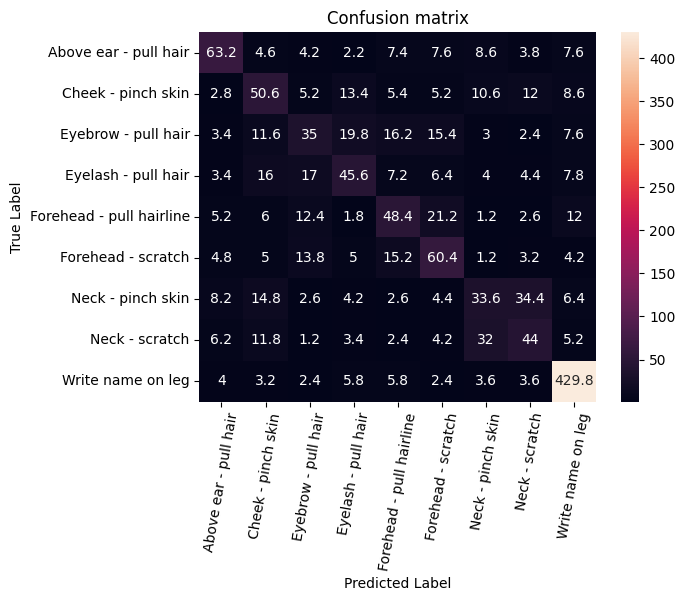

In [70]:
fold = get_avg_fold(folds_score)

macro = fold["f1_macro"]
binary = fold["f1_binary"]

competition_eval = fold["competition_evaluation"]
cm = fold['confusion_matrix']

print(f'macro: {macro:.2f}, binary: {binary:.2f}, competition: {competition_eval:.2f}')

plot_cm(cm, list(encoder.classes_))
fold["classification_report"]

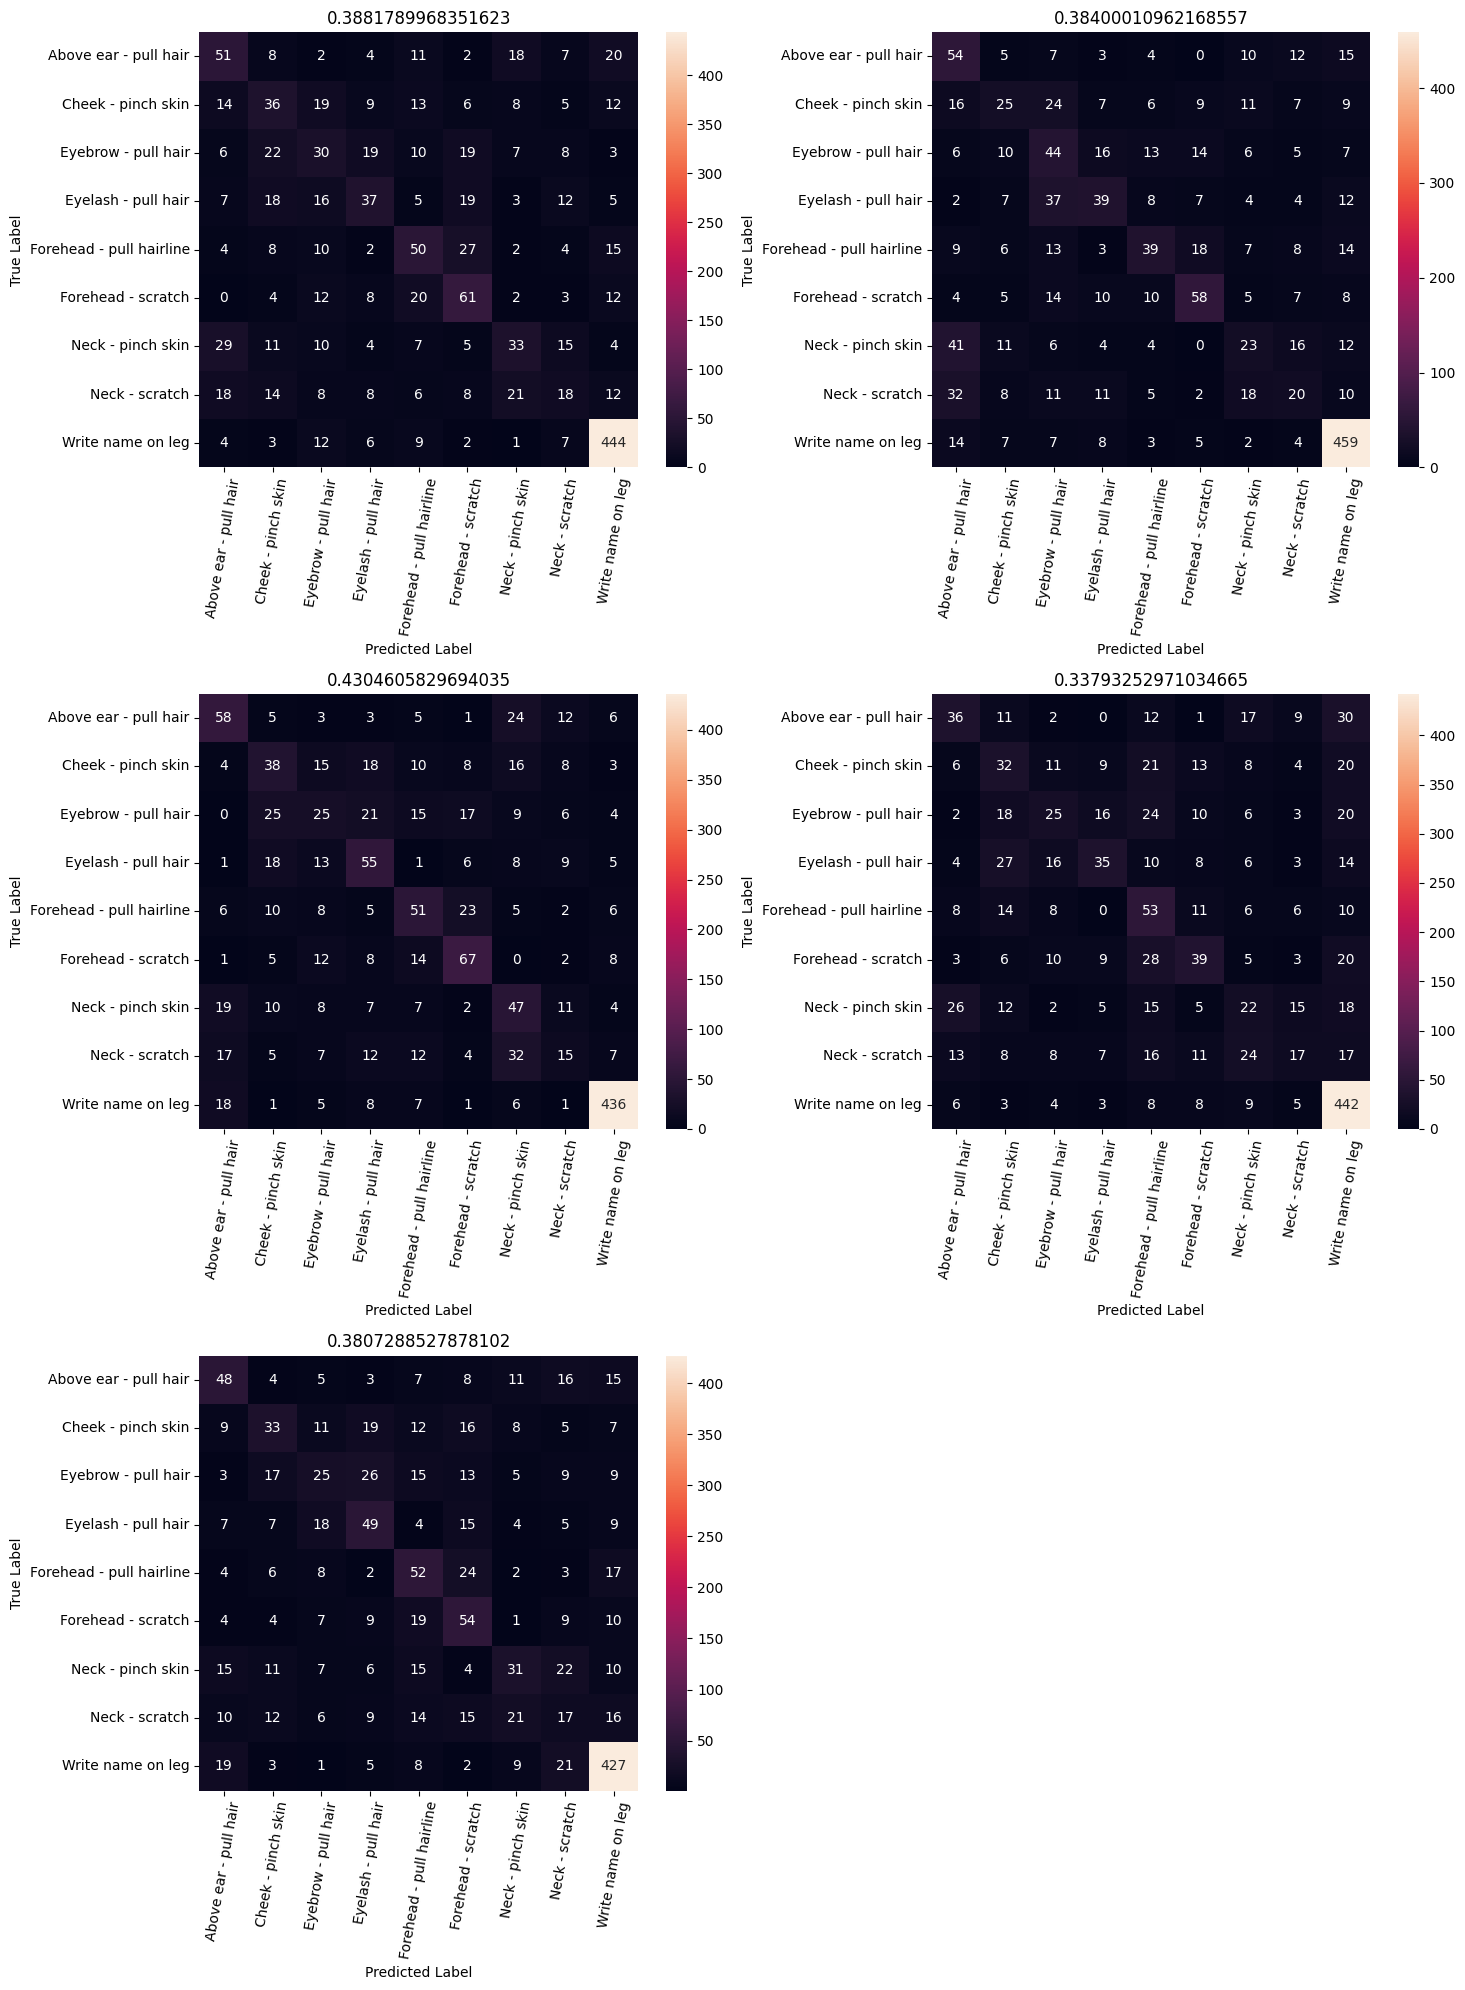

In [29]:
plt.figure(figsize=(15, 20))
for i, fold in enumerate(folds_score, start=1):
    plt.subplot(3, 2, i)
    plot_cm(fold["confusion_matrix"], list(encoder.classes_))
    plt.title(fold['f1_macro'])

plt.tight_layout()
# plt.subplots_adjust(hspace=0.8)

good subjects: ['SUBJ_003328' 'SUBJ_004117' 'SUBJ_017499' 'SUBJ_020948' 'SUBJ_027671'
 'SUBJ_030676' 'SUBJ_036450' 'SUBJ_040282' 'SUBJ_040733' 'SUBJ_041770'
 'SUBJ_047636' 'SUBJ_052342' 'SUBJ_053906' 'SUBJ_054811' 'SUBJ_056936'
 'SUBJ_058967']
bad subjects: ['SUBJ_008304' 'SUBJ_013623' 'SUBJ_019262' 'SUBJ_019756' 'SUBJ_023739'
 'SUBJ_024137' 'SUBJ_026460' 'SUBJ_032233' 'SUBJ_038277' 'SUBJ_040106'
 'SUBJ_042779' 'SUBJ_042794' 'SUBJ_045235' 'SUBJ_050642' 'SUBJ_059960']


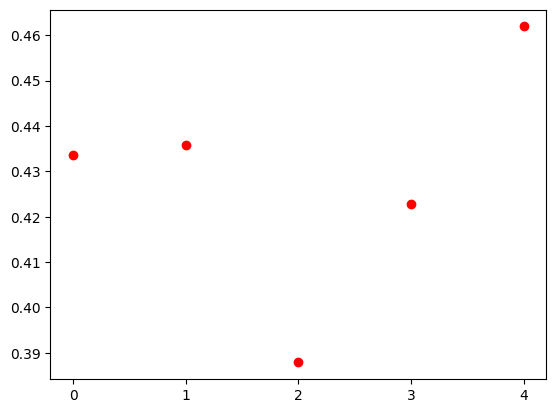

In [359]:
macros = [f["f1_macro"] for f in folds_score]
plt.plot(np.arange(len(macros)), macros, 'ro')
plt.xticks(np.arange(len(macros)))

bad_idx = 2
good_idx = 4

print(f'good subjects: {test_subjects[good_idx]}')
print(f'bad subjects: {test_subjects[bad_idx]}')

KeyboardInterrupt: 

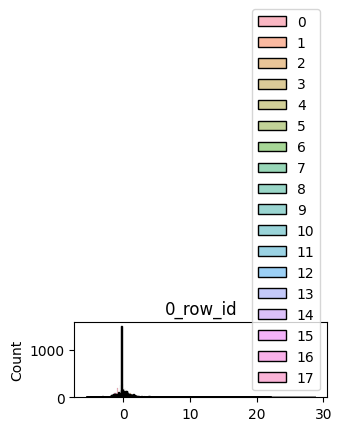

In [275]:
# sub_df = pd.DataFrame(
#     {
#         "value": np.concat([data_good, data_bad]),
#         "fold": ["good"] * len(data_good) + ["bad"] * len(data_bad),
#     }
# )


graph_idx = 1
plt.figure(figsize=(15, 15))
for feature_idx in range(0, X_train_arr[0].shape[1]):
    data_good = X_test_arr[good_idx][:, feature_idx]
    data_bad = X_test_arr[bad_idx][:, feature_idx]

    plt.subplot(13, 4, graph_idx)
    plt.title(f"{feature_idx}_{filtered_df.columns[feature_idx]}")
    sns.histplot(data_good, label="good")
    sns.histplot(data_bad, alpha=0.7, label="bad")
    plt.legend()

    graph_idx += 1

plt.tight_layout()

<Axes: ylabel='Count'>

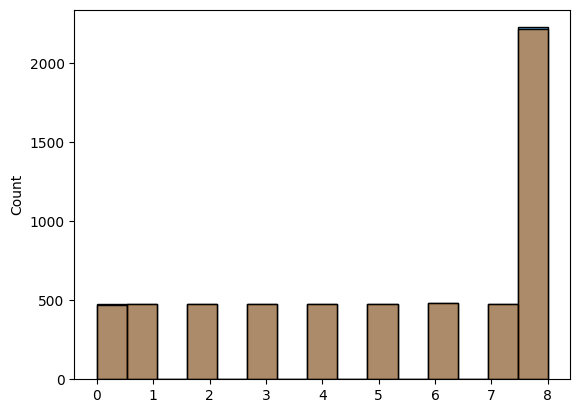

In [276]:
sns.histplot(y_train_arr[good_idx])
sns.histplot(y_train_arr[bad_idx], alpha=0.5)

In [ ]:
# final train model
n_epochs = 400
model = SimpleModel(len(encoder.classes_))

dataset_all = TensorDataset(features_tensor, target_tensor)
dataloader_all = DataLoader(dataset_all, batch_size=batch_size, shuffle=True)

train_model(model, dataloader_all, n_epochs, should_log=True)
torch.save(model.state_dict, '../models/model.pth')

0 - loss_avg: 1.7670864285901189
20 - loss_avg: 1.3435163935646415
40 - loss_avg: 1.2941331644542515
60 - loss_avg: 1.2580602089874446
80 - loss_avg: 1.2367916163057089
100 - loss_avg: 1.2189869447611272
120 - loss_avg: 1.2041548932902515
140 - loss_avg: 1.1891458523459733
160 - loss_avg: 1.1784265250898898
180 - loss_avg: 1.1631644000299275
200 - loss_avg: 1.1489455755800009
220 - loss_avg: 1.1393039487302303
240 - loss_avg: 1.130943219177425
260 - loss_avg: 1.1241767010651529
280 - loss_avg: 1.1117427400313318
300 - loss_avg: 1.1023416174575686
320 - loss_avg: 1.0911986152641475
340 - loss_avg: 1.0916559724137187
360 - loss_avg: 1.0821397854015231
380 - loss_avg: 1.0796014992520213
